In [1]:
import os
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, auc
from scipy.stats import rankdata

In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent.parent
print(PATH_ROOT)

/home/lukec/workspace/applicabilityDomain


In [3]:
CLASSIFIERS = ['KNeighborsClassifier', 'NNClassifier', 'RandomForestClassifier', 'SVC']
CLF_alias = ['KNN', 'NN', 'RF', 'SVM']
AD = ['DAIndexDelta', 
      'DAIndexGamma', 
      'DAIndexKappa', 
      'PCABoundingBox', 
      'ProbabilityClassifier', 
      'Magnet',
      'SklearnFeatureSqueezing', 
      'SklearnRegionBasedClassifier',
]
AD_alias = ['DM-δ',
            'DM-γ',
            'DM-κ',
            'BB',
            'Prob.',
            'Magnet',
            'FS',
            'RC'
]
AL = ['Magnet', 'FS', 'RC']
DATASETS = ['Ames', 'BBBP', 'Cancer', 'CYP1A2', 'hERG', 'HIV', 'Liver']

In [4]:
def get_data_path(model, ad, dataset, suffix='roc'):
    """Return a full path of the ROC results;"""
    path_file = os.path.join(PATH_ROOT, 'results', f'{model}_{ad}', f'{dataset}_{suffix}.csv')
    return path_file

# Test function
df_test = pd.read_csv(get_data_path(CLASSIFIERS[0], AD[0], DATASETS[0]))
df_test.head()

,cv1_fpr,cv1_tpr,cv2_fpr,cv2_tpr,cv3_fpr,cv3_tpr,cv4_fpr,cv4_tpr,cv5_fpr,cv5_tpr
0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1,0.00099,0.000000,0.000000,0.003236,0.000000,0.003636,0.000999,0.000000,0.00000,0.003559
2,0.00099,0.003425,0.002016,0.003236,0.001949,0.003636,0.000999,0.003333,0.00000,0.010676
3,0.00495,0.003425,0.002016,0.009709,0.001949,0.010909,0.002997,0.003333,0.00098,0.010676
4,0.00495,0.006849,0.004032,0.009709,0.002924,0.010909,0.002997,0.006667,0.00098,0.014235


In [5]:
def get_mean_tpr(clf, ad, dataset):
    """Get TPR on 5-fold CV on 1 dataset with 1 classifier and 1 AD method;"""
    mean_fpr = np.linspace(0, 1, 100)
    df = pd.read_csv(get_data_path(clf, ad, dataset))
    tpr = []
    # Results are saved as 5-fold CV, starts from 1 to 5;
    for i in range(1, 6):
        fold_fpr = df[f'cv{i}_fpr'].dropna().to_numpy()
        fold_tpr = df[f'cv{i}_tpr'].dropna().to_numpy()
        interp_tpr = np.interp(mean_fpr, fold_fpr, fold_tpr)
        interp_tpr[0] = 0.
        tpr.append(interp_tpr)

    mean_tpr = np.mean(tpr, axis=0)
    mean_tpr[-1] = 1.0
    mean_tpr = pd.Series(mean_tpr)
    return mean_tpr

# Test function
res_test = get_mean_tpr(CLASSIFIERS[0], AD[0], DATASETS[0])
print(res_test)

0     0.000000
1     0.019244
2     0.035791
3     0.051066
4     0.075846
        ...   
95    0.980451
96    0.984066
97    0.987680
98    0.991295
99    1.000000
Length: 100, dtype: float64


In [6]:
def get_df_roc(clf, dataset):
    """Get a DataFrame that contains all AD method on 1 dataset and 1 classifier;""" 
    _df = pd.DataFrame({ 'fpr': np.linspace(0, 1, 100) })

    for ad, ad_lbl in zip(AD, AD_alias):
        # print(i, ad, ad_lbl)
        _tpr = get_mean_tpr(clf, ad, dataset)
        _df = pd.concat((_df, pd.DataFrame({ ad_lbl: _tpr })), axis=1)
    return _df

# Test function
df_test = get_df_roc(CLASSIFIERS[0], DATASETS[0])
df_test.head()

,fpr,DM-δ,DM-γ,DM-κ,BB,Prob.,Magnet,FS,RC
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.010101,0.019244,0.017036,0.022883,0.011099,0.025762,0.043132,0.089057,0.070202
2,0.020202,0.035791,0.042185,0.037495,0.022198,0.051525,0.080093,0.163377,0.112918
3,0.030303,0.051066,0.057237,0.056757,0.033296,0.077287,0.109274,0.213623,0.159961
4,0.040404,0.075846,0.071632,0.063039,0.044395,0.103049,0.136566,0.250469,0.196816


In [7]:
def get_auc(clf, clf_alias, dataset):
    df_auc = pd.DataFrame({
    'Dataset': [],
    'Classifier': [],
    'Method': [],
    'AUC': [],
    })
    df_roc = get_df_roc(clf, dataset)
    for i, ad in enumerate(df_roc.columns[1:]):
        auc_score = auc(df_roc['fpr'], df_roc[ad])
        row = [
            dataset,
            clf_alias,
            ad,
            auc_score
        ]
        df_auc.loc[len(df_auc)] = row
    # Largest one should be #1.
    # Use 'min' for the tie, e.g, [1, 2, 2, 4]
    df_auc['Rank'] = rankdata(-df_auc['AUC'], method='min')
    return df_auc


# Test function
df_test = get_auc(CLASSIFIERS[0], CLF_alias[0], DATASETS[0])
df_test


,Dataset,Classifier,Method,AUC,Rank
0,Ames,KNN,DM-δ,0.586356,7
1,Ames,KNN,DM-γ,0.601921,5
2,Ames,KNN,DM-κ,0.587643,6
3,Ames,KNN,BB,0.528490,8
4,Ames,KNN,Prob.,0.705766,2
5,Ames,KNN,Magnet,0.622429,4
6,Ames,KNN,FS,0.727547,1
7,Ames,KNN,RC,0.705669,3


In [8]:
df_auc = pd.DataFrame()
for dataset in DATASETS:
    for clf, alias in zip(CLASSIFIERS, CLF_alias):
        _df = get_auc(clf, alias, dataset)
        df_auc = pd.concat((df_auc, _df), ignore_index=True)

path_output = os.path.join(PATH_ROOT, 'plot_results', 'roc', 'auc.csv')
print('Save to:', path_output)
df_auc.to_csv(path_output, index=False)

df_auc

Save to: /home/lukec/workspace/applicabilityDomain/plot_results/roc/auc.csv


,Dataset,Classifier,Method,AUC,Rank
0,Ames,KNN,DM-δ,0.586356,7
1,Ames,KNN,DM-γ,0.601921,5
2,Ames,KNN,DM-κ,0.587643,6
3,Ames,KNN,BB,0.528490,8
4,Ames,KNN,Prob.,0.705766,2
...,...,...,...,...,...
219,Liver,SVM,BB,0.480144,8
220,Liver,SVM,Prob.,0.654888,1
221,Liver,SVM,Magnet,0.644450,2
222,Liver,SVM,FS,0.634226,3


In [9]:
df_auc['AUC'] = df_auc['AUC'].apply(lambda x: max((1- x), x))

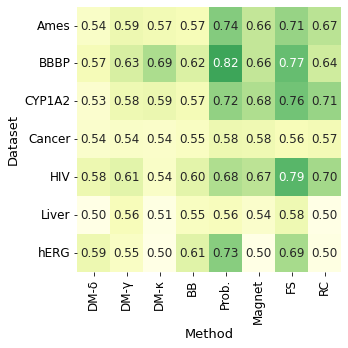

In [10]:
def create_auc_heatmap(df, classifier, output=None, fontsize=12, figsize=(5, 5)):
    """Plot heatmap per classifier."""
    df_selected = df[df['Classifier'] == classifier]
    heatmap_data = df_selected.pivot('Dataset', 'Method', 'AUC')
    
    plt.rc('font', size=fontsize)
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap_data, 
                xticklabels=AD_alias,
                cmap='YlGn',
                annot=True, 
                fmt='.2f', 
                cbar=False,
                vmin=0.5,
                vmax=1)
    plt.xlabel('Method', fontsize=fontsize+1)
    plt.ylabel('Dataset', fontsize=fontsize+1)
    plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
    else:
        plt.show()

# Test function
create_auc_heatmap(df_auc, 'NN')

Save to: /home/lukec/workspace/applicabilityDomain/plot_results/roc/KNN_auc_heatmap.pdf
Save to: /home/lukec/workspace/applicabilityDomain/plot_results/roc/NN_auc_heatmap.pdf
Save to: /home/lukec/workspace/applicabilityDomain/plot_results/roc/RF_auc_heatmap.pdf
Save to: /home/lukec/workspace/applicabilityDomain/plot_results/roc/SVM_auc_heatmap.pdf


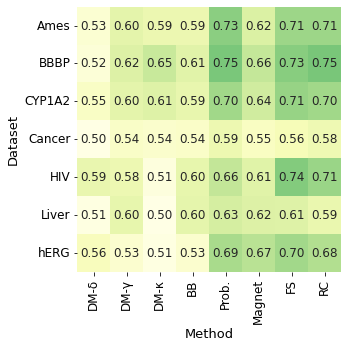

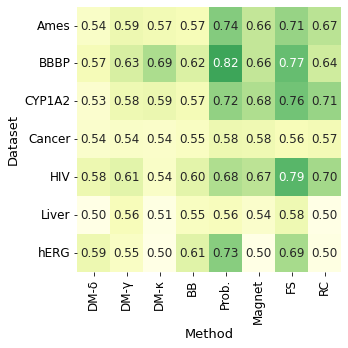

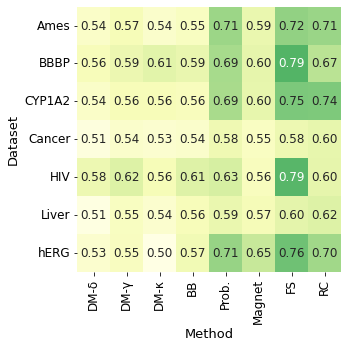

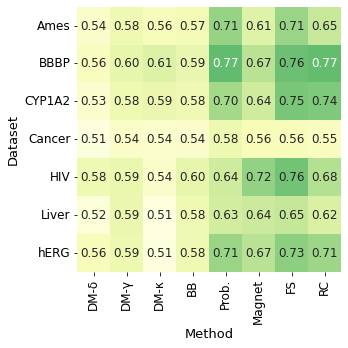

In [11]:
for clf in CLF_alias:
    path_output = os.path.join(PATH_ROOT, 'plot_results', 'roc', f'{clf}_auc_heatmap.pdf')
    print('Save to:', path_output)
    create_auc_heatmap(df_auc, clf, output=path_output)